# Objective of this Notebook

## Measure Collaborative Fluency of Teams in Random0: Forced Coordination Case

1. Passing Efficiency

## Import Dependencies

In [1]:
# %matplotlib inline
# %matplotlib notebook
import tqdm, copy
import random, os
import pandas as pd
from tqdm import trange
import matplotlib.pyplot as plt
from collections import defaultdict
from overcooked_ai_py.utils import save_pickle
from human_aware_rl.utils import set_global_seed
from human_aware_rl.human.process_dataframes import *
from human_aware_rl.static import *
import pickle as pkl

set_global_seed(1884)

In [2]:
import ast
import json

from scipy import stats


# Define Helper Functions

In [3]:
def json_eval(s):
    json_acceptable_string = s.replace("'", "\"")
    d = json.loads(json_acceptable_string)
    return d

In [4]:

def plot_trial(trial_id, p1_data, p2_data, objects_data, name, title):
        
    N_steps = len(p1_data)
    a_min = 1    # the minimial value of the paramater a
    a_max = N_steps-1   # the maximal value of the paramater a
    a_init = 1   # the value of the parameter a to be used initially, when the graph is created

    t = np.linspace(0, N_steps-1, N_steps)
    
    
    layout = eval(old_trials[old_trials['layout_name']==name]['layout'].to_numpy()[0])
    layout = np.array([list(elem) for elem in layout])
    grid_display = np.zeros((layout.shape[0], layout.shape[1], 3))
    for i in range(layout.shape[0]):
        for j in range(layout.shape[1]):
            # Floor = gray
            grid_display[i,j,:] = [220,220,220]
            if layout[i,j] == 'X':
                # Counter = Tan
                grid_display[i,j,:] = [91,153,91]
            if layout[i,j] == 'P':
                # Pots = brown
                grid_display[i,j,:] = [139,69,19]
            if layout[i,j] == 'S':
                # Serve = Green
                grid_display[i,j,:] = [34,139,34]
            if layout[i,j] == 'O':
                # Onion = Yellow
                grid_display[i,j,:] = [218,165,32]
            if layout[i,j] == 'D':
                # Dishes = Blue
                grid_display[i,j,:] = [65,105,225]
            if layout[i,j] == 'T':
                # Tomato = Blue
                grid_display[i,j,:] = [255,69,0]


    # loop over your images
    for a in range(len(t)):

        fig = plt.figure(figsize=(8,3))

        sin_ax = plt.axes([0.1, 0.2, 0.8, 0.65])

        plt.axes(sin_ax) # select sin_ax

        plt.imshow(grid_display.astype(np.uint8), vmin=0, vmax=255)


        scat1 = plt.scatter(f_p1(t, a, p1_data)[0], f_p1(t, a, p1_data)[1], lw=20, c='r')
        line1, = plt.plot(f_p1(t, a, p1_data)[0], f_p1(t, a, p1_data)[1], lw=5, c='r')

        arrow1 = plt.arrow(arrow_p1(t, a, p1_data)[0], arrow_p1(t, a, p1_data)[1], 
                           arrow_p1(t, a, p1_data)[2], arrow_p1(t, a, p1_data)[3], head_width=0.5,
                           head_length=0.5, width=0.02, fc='r', ec='r', length_includes_head=True)

        if obj_p1(t, a, p1_data)[0] is not None:
            arrow_obj1 = plt.scatter(obj_p1(t, a, p1_data)[0], obj_p1(t, a, p1_data)[1], 
                                     lw=10, c=obj_p1(t, a, p1_data)[3])


        scat2 = plt.scatter(f_p2(t, a, p2_data)[0], f_p2(t, a, p2_data)[1], lw=20, c='b')
        line2, = plt.plot(f_p2(t, a, p2_data)[0], f_p2(t, a, p2_data)[1], lw=5, c='b')

        arrow2 = plt.arrow(arrow_p2(t, a, p2_data)[0], arrow_p2(t, a, p2_data)[1], 
                           arrow_p2(t, a, p2_data)[2], arrow_p2(t, a, p2_data)[3], head_width=0.5,
                           head_length=0.5, width=0.02, fc='b', ec='b', length_includes_head=True)

        if obj_p2(t, a, p2_data)[0] is not None:
            arrow_obj2 = plt.scatter(obj_p2(t, a, p2_data)[0], obj_p2(t, a, p2_data)[1], 
                                     lw=10, c=obj_p2(t, a, p2_data)[3])

        objects_list = world_obj(t, a, objects_data)
        for obj in objects_list:
            obj_add = plt.scatter(obj[0], obj[1], 
                                     lw=10, c=obj[2])

        trial_name = name + '_'+str(trial_id)
        if not os.path.exists(trial_name):
            os.makedirs(trial_name)

        plt.savefig(trial_name+'/im_'+str(a)+'.png')
        plt.close()


In [5]:

def f_p1(t, a, p1_data):
    t_partial = t[int(a)-1:int(a)]
#     print('t_input', t)
    return [p1_data[int(j)]['position'][0] for j in t_partial], [p1_data[int(j)]['position'][1] for j in t_partial]
def f_p2(t, a, p2_data):
    t_partial = t[int(a)-1:int(a)]
    return [p2_data[int(j)]['position'][0] for j in t_partial], [p2_data[int(j)]['position'][1] for j in t_partial]



def arrow_p1(t, a, p1_data):
#     t_partial = t[int(a)-1:int(a)+1]
#     print('t_input', t)
    return p1_data[int(a)]['position'][0], p1_data[int(a)]['position'][1],\
            p1_data[int(a)]['orientation'][0], p1_data[int(a)]['orientation'][1]
def arrow_p2(t, a, p2_data):
    return p2_data[int(a)]['position'][0], p2_data[int(a)]['position'][1],\
            p2_data[int(a)]['orientation'][0], p2_data[int(a)]['orientation'][1]


def held_p1(t, a, p1_data):
    return p1_data[int(a)]['position'][0], p1_data[int(a)]['position'][1],\
            p1_data[int(a)]['orientation'][0], p1_data[int(a)]['orientation'][1]
def held_p2(t, a, p2_data):
    return p2_data[int(a)]['position'][0], p2_data[int(a)]['position'][1],\
            p2_data[int(a)]['orientation'][0], p2_data[int(a)]['orientation'][1]


def world_obj(t, a, objects_data):
    obj_world = objects_data[int(a)]
    if len(obj_world)==0:
        return []
    objects_list = []
    for i in range(len(obj_world)):
        obj = obj_world[i]
        name = obj_world[i]['name']
        position = obj_world[i]['position']
        if name == 'onion':
            color = 'y'
            objects_list.append((position[0], position[1], name, color))
        if name == 'dish':
            color = 'k'
            objects_list.append((position[0], position[1], name, color))
        if name == 'soup':
            if obj['is_cooking'] is True:
                color = 'r'
            elif obj['is_ready'] is True:
                color = 'g'
            else:
                color = 'orange'
            objects_list.append((position[0], position[1], name, color))
        
    return objects_list


def obj_p1(t, a, p1_data):
#     t_partial = t[int(a)-1:int(a)+1]
#     print('t_input', t)
    color = 'k'
    if p1_data[int(a)]['held_object'] is None:
        return [None, None, None, None]
    else:
        name = p1_data[int(a)]['held_object']['name']
        if name == 'dish':
            color = 'k'
        elif name == 'onion':
            color = 'y'
    return p1_data[int(a)]['position'][0], p1_data[int(a)]['position'][1], p1_data[int(a)]['held_object']['name'], color

def obj_p2(t, a, p2_data):
    color = 'k'
    if p2_data[int(a)]['held_object'] is None:
        return [None, None, None, None]
    else:
        name = p2_data[int(a)]['held_object']['name']
        if name == 'dish':
            color = 'k'
        elif name == 'onion':
            color = 'y'
    return p2_data[int(a)]['position'][0], p2_data[int(a)]['position'][1], p2_data[int(a)]['held_object']['name'], color


# [{'name': 'soup',
#    'position': [4, 1],
#    '_ingredients': [{'name': 'onion', 'position': [4, 1]},
#     {'name': 'onion', 'position': [4, 1]}],
#    'cooking_tick': -1,
#    'is_cooking': False,
#    'is_ready': False,
#    'is_idle': True,
#    'cook_time': -1,
#    '_cooking_tick': -1}],

NORTH = (0, -1)
SOUTH = (0, 1)
EAST  = (1, 0)
WEST  = (-1, 0)
STAY = (0,0)
INTERACT = 'INTERACT'
# STAY = [0,0]

def action_p1(t, a, p1_data):
    if p1_data[int(a)] == 'INTERACT':
        act = 'I'
    else:
        x, y = p1_data[int(a)][0], p1_data[int(a)][1]
        act = 'N'
        if (x,y) == NORTH:
            act = 'N'
        if (x,y) == SOUTH:
            act = 'S'
        if (x,y) == EAST:
            act = 'E'
        if (x,y) == WEST:
            act = 'W'
        if (x,y) == STAY:
            act = 'Y'
        
    return act

def action_p2(t, a, p2_data):
    if p2_data[int(a)] == 'INTERACT':
        act = 'I'
    else:
        x, y = p2_data[int(a)][0], p2_data[int(a)][1]
        act = 'N'
        if (x,y) == NORTH:
            act = 'N'
        if (x,y) == SOUTH:
            act = 'S'
        if (x,y) == EAST:
            act = 'E'
        if (x,y) == WEST:
            act = 'W'
        if (x,y) == STAY:
            act = 'Y'
        
    return act





# Import Cleaned Data

In [6]:
hh_all_2020_file = '/Users/michellezhao/Documents/overcooked_research/human_aware_rl/human_aware_rl/static/human_data/cleaned/2020_hh_trials_all.pickle'
hh_all_2019_file = '/Users/michellezhao/Documents/overcooked_research/human_aware_rl/human_aware_rl/static/human_data/cleaned/2019_hh_trials_all.pickle'






In [7]:
with open(hh_all_2020_file,'rb') as file:
    humans_2020_file = pkl.load(file)
    
with open(hh_all_2019_file,'rb') as file:
    humans_2019_file = pkl.load(file)



In [8]:
humans_2020_file.to_csv('humans_all_2020.csv')

In [9]:
humans_2019_file.to_csv('humans_all_2019.csv')

In [10]:
humans_2020_file.columns

Index(['state', 'joint_action', 'reward', 'time_left', 'score', 'time_elapsed',
       'cur_gameloop', 'layout', 'layout_name', 'trial_id', 'player_0_id',
       'player_1_id', 'player_0_is_human', 'player_1_is_human',
       'cur_gameloop_total', 'score_total', 'button_press',
       'button_press_total', 'timesteps_since_interact',
       'button_presses_per_timstep'],
      dtype='object')

In [11]:
old_trials = humans_2019_file
new_trials = humans_2020_file

In [12]:
all_trials = pd.concat([old_trials, new_trials])

In [13]:
all_trials.columns

Index(['Unnamed: 0', 'cur_gameloop', 'joint_action', 'layout', 'layout_name',
       'reward', 'score', 'state', 'time_elapsed', 'time_left', 'trial_id',
       'player_0_is_human', 'player_1_is_human', 'player_0_id', 'player_1_id',
       'cur_gameloop_total', 'score_total', 'button_press',
       'button_press_total', 'timesteps_since_interact',
       'button_presses_per_timstep'],
      dtype='object')

In [14]:
len(all_trials['trial_id'].unique())

373

# Process Data From Forced Coordination

In [17]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import os
from ast import literal_eval

# Use Agg backend for canvas
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas


layout_trials = old_trials[old_trials['layout_name']=='random0']['trial_id'].unique()
name = 'random0'
title = 'Forced Coordination'

for j in range(len(layout_trials)):
# for j in [1]:
    trial_id = layout_trials[j]
    print('trial_id', trial_id)
    trial_df = old_trials[old_trials['trial_id']==trial_id]
    score = old_trials[old_trials['trial_id']==trial_id]['score'].to_numpy()[-1]
    state_data = trial_df['state'].to_numpy()
    joint_actions = trial_df['joint_action'].to_numpy()
    
    p1_data = []
    p2_data = []
    p1_actions = []
    p2_actions = []
    state_data_eval = []
    objects_data = []
    for i in range(1, len(state_data)):
        prev_state_x = json_eval(state_data[i-1])
        state_x = json_eval(state_data[i])
        joint_actions_i = literal_eval(joint_actions[i])
#         print('joint_actions', joint_actions)
        
        if state_x['players'][0]['position'][0] == 1:
            p1_index = 0
            p2_index = 1
        else:
            p1_index = 1
            p2_index = 0
        p1_data.append(state_x['players'][p1_index])
        p2_data.append(state_x['players'][p2_index])
        state_data_eval.append(state_x)
        objects_data.append(state_x['objects'])
        
        p1_actions.append(joint_actions_i[p1_index])
        p2_actions.append(joint_actions_i[p2_index])
#         break
        
    break

    

trial_id 9


In [21]:
index = 1
state_x['players'][1]['position'][0]==1

True

# Plot Some Aggregate Measures

In [15]:

layout_trials = old_trials[old_trials['layout_name']=='random0']['trial_id'].unique()
name = 'random0'
title = 'Forced Coordination'

trial_to_score = {}


for j in range(len(layout_trials)):
# for j in [1]:
    
    trial_id = layout_trials[j]
    trial_to_score[trial_id] = {}
    print('trial_id', trial_id)
    
    trial_df = old_trials[old_trials['trial_id']==trial_id]
    score = old_trials[old_trials['trial_id']==trial_id]['score'].to_numpy()[-1]
    state_data = trial_df['state'].to_numpy()
    p1_data = []
    p2_data = []
    state_data_eval = []
    objects_data = []
    for i in range(1, len(state_data)):
        prev_state_x = json_eval(state_data[i-1])
        state_x = json_eval(state_data[i])
        p1_data.append(state_x['players'][0])
        p2_data.append(state_x['players'][1])
        state_data_eval.append(state_x)
        objects_data.append(state_x['objects'])
        
    trial_to_score[trial_id]['p1_length'] = len(p1_data)
    trial_to_score[trial_id]['p2_length'] = len(p2_data)
    
    trial_to_score[trial_id]['score'] = score

    

trial_id 9
trial_id 14
trial_id 19
trial_id 24
trial_id 54
trial_id 59
trial_id 64
trial_id 69
trial_id 79
trial_id 89
trial_id 99
trial_id 114


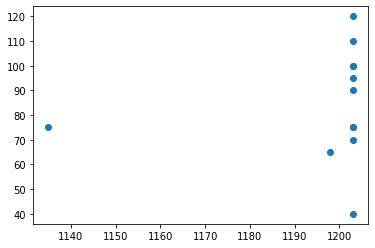

In [27]:
trial_keys = [elem for elem in trial_to_score]
scores = [trial_to_score[elem]['score'] for elem in trial_to_score]
p1_steps = [trial_to_score[elem]['p1_length'] for elem in trial_to_score]
p2_steps = [trial_to_score[elem]['p2_length'] for elem in trial_to_score]

plt.scatter(p2_steps, scores)
plt.show()

In [28]:
old_trials

,Unnamed: 0,cur_gameloop,joint_action,layout,layout_name,reward,score,state,time_elapsed,time_left,...,player_0_is_human,player_1_is_human,player_0_id,player_1_id,cur_gameloop_total,score_total,button_press,button_press_total,timesteps_since_interact,button_presses_per_timstep
0,0,0.0,"[[0, 0], [0, 0]]","['XXPXX', 'O 2O', 'X1 X', 'XDXSX']",cramped_room,0.0,0.0,"{""players"": [{""position"": [1, 2], ""orientation...",0.154,180.0,...,True,True,2,3,1203,0.0,0,373,0,0.310058
1,1,1.0,"[[0, 0], [0, 0]]","['XXPXX', 'O 2O', 'X1 X', 'XDXSX']",cramped_room,0.0,0.0,"{""players"": [{""position"": [1, 2], ""orientation...",0.312,180.0,...,True,True,2,3,1203,0.0,0,373,1,0.310058
2,2,2.0,"[[0, 0], [0, 0]]","['XXPXX', 'O 2O', 'X1 X', 'XDXSX']",cramped_room,0.0,0.0,"{""players"": [{""position"": [1, 2], ""orientation...",0.461,180.0,...,True,True,2,3,1203,0.0,0,373,2,0.310058
3,3,3.0,"[[0, 0], [0, 0]]","['XXPXX', 'O 2O', 'X1 X', 'XDXSX']",cramped_room,0.0,0.0,"{""players"": [{""position"": [1, 2], ""orientation...",0.614,179.0,...,True,True,2,3,1203,0.0,0,373,3,0.310058
4,4,4.0,"[[0, 0], [0, 0]]","['XXPXX', 'O 2O', 'X1 X', 'XDXSX']",cramped_room,0.0,0.0,"{""players"": [{""position"": [1, 2], ""orientation...",1.043,179.0,...,True,True,2,3,1203,0.0,0,373,4,0.310058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117553,117553,1199.0,"[[0, 0], [0, 0]]","['XXXPX', 'X 1 P', 'D2X X', 'O X', 'XOSXX']",coordination_ring,0.0,0.0,"{""players"": [{""position"": [1, 3], ""orientation...",180.003,0.0,...,True,True,48,49,1204,0.0,0,539,238,0.447674
117554,117554,1200.0,"[[0, 0], [-1, 0]]","['XXXPX', 'X 1 P', 'D2X X', 'O X', 'XOSXX']",coordination_ring,0.0,0.0,"{""players"": [{""position"": [1, 3], ""orientation...",180.152,0.0,...,True,True,48,49,1204,0.0,1,539,239,0.447674
117555,117555,1201.0,"[[0, 0], [0, 0]]","['XXXPX', 'X 1 P', 'D2X X', 'O X', 'XOSXX']",coordination_ring,0.0,0.0,"{""players"": [{""position"": [1, 3], ""orientation...",180.302,0.0,...,True,True,48,49,1204,0.0,0,539,240,0.447674
117556,117556,1202.0,"[[0, 0], [-1, 0]]","['XXXPX', 'X 1 P', 'D2X X', 'O X', 'XOSXX']",coordination_ring,0.0,0.0,"{""players"": [{""position"": [1, 3], ""orientation...",180.452,0.0,...,True,True,48,49,1204,0.0,1,539,241,0.447674


In [29]:
old_trials.columns

Index(['Unnamed: 0', 'cur_gameloop', 'joint_action', 'layout', 'layout_name',
       'reward', 'score', 'state', 'time_elapsed', 'time_left', 'trial_id',
       'player_0_is_human', 'player_1_is_human', 'player_0_id', 'player_1_id',
       'cur_gameloop_total', 'score_total', 'button_press',
       'button_press_total', 'timesteps_since_interact',
       'button_presses_per_timstep'],
      dtype='object')

In [34]:
old_trials['joint_action'].unique()

array(['[[0, 0], [0, 0]]', '[[0, -1], [0, 0]]', '[[-1, 0], [0, 0]]',
       "['INTERACT', [0, 0]]", '[[1, 0], [0, 0]]', '[[0, 0], [1, 0]]',
       '[[0, 1], [0, 0]]', '[[0, 1], [-1, 0]]', '[[0, 0], [-1, 0]]',
       "['INTERACT', [0, 1]]", '[[0, 0], [0, 1]]', '[[0, 1], [0, 1]]',
       '[[-1, 0], [1, 0]]', '[[0, -1], [1, 0]]', '[[-1, 0], [-1, 0]]',
       '[[1, 0], [1, 0]]', '[[0, 0], [0, -1]]', "['INTERACT', [-1, 0]]",
       '[[1, 0], [-1, 0]]', '[[1, 0], [0, 1]]', '[[0, -1], [-1, 0]]',
       '[[0, 1], [1, 0]]', '[[-1, 0], [0, 1]]', '[[0, -1], [0, 1]]',
       '[[0, -1], [0, -1]]', "['INTERACT', 'INTERACT']",
       "['INTERACT', [0, -1]]", "[[-1, 0], 'INTERACT']",
       "[[1, 0], 'INTERACT']", "[[0, 0], 'INTERACT']",
       '[[-1, 0], [0, -1]]', "['INTERACT', [1, 0]]", '[[0, 1], [0, -1]]',
       "[[0, 1], 'INTERACT']", "[[0, -1], 'INTERACT']",
       '[[1, 0], [0, -1]]'], dtype=object)

In [39]:
old_trials[old_trials['joint_action']=="['INTERACT', 'INTERACT']"]['state'].to_numpy()[0]

'{"players": [{"position": [1, 1], "orientation": [-1, 0], "held_object": null}, {"position": [2, 1], "orientation": [-1, 0], "held_object": null}], "objects": [], "bonus_orders": [], "all_orders": [{"ingredients": ["onion"]}, {"ingredients": ["onion", "onion"]}, {"ingredients": ["onion", "onion", "onion"]}, {"ingredients": ["tomato"]}, {"ingredients": ["tomato", "tomato"]}, {"ingredients": ["tomato", "tomato", "tomato"]}, {"ingredients": ["onion", "tomato"]}, {"ingredients": ["onion", "onion", "tomato"]}, {"ingredients": ["onion", "tomato", "tomato"]}], "timestep": 0}'

In [ ]:
# NORTH = (0, -1)
# SOUTH = (0, 1)
# EAST  = (1, 0)
# WEST  = (-1, 0)
# INTERACT
# STAY = [0,0]


# 1. Compute Passing Efficiency

In [96]:
N_steps = len(p1_data)
a_min = 1    # the minimial value of the paramater a
a_max = N_steps-1   # the maximal value of the paramater a
a_init = 1   # the value of the parameter a to be used initially, when the graph is created

t = np.linspace(0, N_steps-1, N_steps)


obj_count_id = 0
next_obj_count_id = 0

layout = eval(old_trials[old_trials['layout_name']==name]['layout'].to_numpy()[0])
layout = np.array([list(elem) for elem in layout])
grid_display = np.zeros((layout.shape[0], layout.shape[1], 3))

# loop over your images
for a in range(len(t)-1):

    p1_x, p1_y = f_p1(t, a, p1_data)[0], f_p1(t, a, p1_data)[1]
    p1_dir_x, p1_dir_y = arrow_p1(t, a, p1_data)[2], arrow_p1(t, a, p1_data)[3]
    p1_obj_x, p1_obj_y, p1_obj_name = obj_p1(t, a, p1_data)[0], \
                obj_p1(t, a, p1_data)[1], \
                obj_p1(t, a, p1_data)[2]
    p1_act = action_p1(t, a, p1_data)
    
    p2_x, p2_y = f_p2(t, a, p1_data)[0], f_p2(t, a, p1_data)[1]
    p2_dir_x, p2_dir_y = arrow_p2(t, a, p2_data)[2], arrow_p2(t, a, p2_data)[3]
    p2_obj_x, p2_obj_y, p2_obj_name = obj_p2(t, a, p2_data)[0], \
                obj_p2(t, a, p2_data)[1], \
                obj_p2(t, a, p2_data)[2]
    p2_act = action_p2(t, a, p2_data)
    
    # cook_state 
    # 0 = uncooked
    # 1 = cooking
    # 2 = cooked
    
    object_list_tracker = {}
    object_location_tracker = {}
    if p1_obj_x is not None:
        obj_location = (p1_obj_x, p1_obj_y)
        object_location_tracker[obj_location] = obj_count_id
        
        object_list_tracker[obj_count_id] = {}
        object_list_tracker[obj_count_id]['name'] = p1_obj_name
        object_list_tracker[obj_count_id]['player_holding'] = 2
        object_list_tracker[obj_count_id]['cook_state'] = 0
        object_list_tracker[obj_count_id]['id'] = obj_count_id
        object_list_tracker[obj_count_id]['time_since_pickup'] = 0
        object_list_tracker[obj_count_id]['location'] = obj_location
        object_list_tracker[obj_count_id]['on_screen'] = True
        
        obj_count_id += 1
        
    if p2_obj_x is not None:
        obj_location = (p2_obj_x, p2_obj_y)
        object_location_tracker[obj_location] = obj_count_id
        
        object_list_tracker[obj_count_id] = {}
        object_list_tracker[obj_count_id]['name'] = p2_obj_name
        object_list_tracker[obj_count_id]['player_holding'] = 2
        object_list_tracker[obj_count_id]['cook_state'] = 0
        object_list_tracker[obj_count_id]['id'] = obj_count_id
        object_list_tracker[obj_count_id]['time_since_pickup'] = 0
        object_list_tracker[obj_count_id]['location'] = obj_location
        object_list_tracker[obj_count_id]['on_screen'] = True
        
        obj_count_id += 1

    objects_list = world_obj(t, a, objects_data)
    for obj in objects_list:
        obj_x, obj_y, obj_name = obj[0], obj[1], obj[2]
        obj_location = (obj_x, obj_y)
        
        object_location_tracker[obj_location] = obj_count_id
        
        object_list_tracker[obj_count_id] = {}
        object_list_tracker[obj_count_id]['name'] = obj_name
        object_list_tracker[obj_count_id]['player_holding'] = 2
        object_list_tracker[obj_count_id]['cook_state'] = 0
        object_list_tracker[obj_count_id]['id'] = obj_count_id
        object_list_tracker[obj_count_id]['time_since_pickup'] = 0
        object_list_tracker[obj_count_id]['location'] = obj_location
        object_list_tracker[obj_count_id]['on_screen'] = True
        
        obj_count_id += 1
        
        
        
    # Second Step
    b = a+1
    p1_x_next, p1_y_next = f_p1(t, b, p1_data)[0], f_p1(t, b, p1_data)[1]
    p1_dir_x_next, p1_dir_y_next = arrow_p1(t, b, p1_data)[2], arrow_p1(t, b, p1_data)[3]
    p1_obj_x_next, p1_obj_y_next, p1_obj_name_next = obj_p1(t, b, p1_data)[0], \
                obj_p1(t, b, p1_data)[1], \
                obj_p1(t, b, p1_data)[2]
    
    p2_x_next, p2_y_next = f_p2(t, b, p1_data)[0], f_p2(t, b, p1_data)[1]
    p2_dir_x_next, p2_dir_y_next = arrow_p2(t, b, p2_data)[2], arrow_p2(t, b, p2_data)[3]
    p2_obj_x_next, p2_obj_y_next, p2_obj_name_next = obj_p2(t, b, p2_data)[0], \
                obj_p2(t, b, p2_data)[1], \
                obj_p2(t, b, p2_data)[2]
        
    # If player 1 turned
    if (p1_dir_x_next, p1_dir_y_next) != (p1_dir_x, p1_dir_y):
        obj_location = (p1_obj_x, p1_obj_y)
        if obj_location in object_location_tracker:
            obj_id = object_location_tracker[obj_location]
            
        
        
    # If player 1 moved
    if (p1_x_next, p1_y_next) != (p1_x, p1_y):
        
        
    # If player 1 put down object onto counter
        
        
        
        
        
  ########## HOLD OFF      
    next_object_list_tracker = {}
    next_object_location_tracker = {}
    if p1_obj_x_next is not None:
        obj_location = (p1_obj_x_next, p1_obj_y_next)
        next_object_location_tracker[obj_location] = obj_count_id
        
        next_object_list_tracker[next_obj_count_id] = {}
        next_object_list_tracker[next_obj_count_id]['name'] = p1_obj_name
        next_object_list_tracker[next_obj_count_id]['player_holding'] = 2
        next_object_list_tracker[next_obj_count_id]['cook_state'] = 0
        next_object_list_tracker[next_obj_count_id]['id'] = obj_count_id
        next_object_list_tracker[next_obj_count_id]['time_since_pickup'] = 0
        next_object_list_tracker[next_obj_count_id]['location'] = obj_location
        next_object_list_tracker[next_obj_count_id]['on_screen'] = True
        
        next_obj_count_id += 1
        
    if p2_obj_x_next is not None:
        obj_location = (p2_obj_x_next, p2_obj_y_next)
        next_object_location_tracker[obj_location] = obj_count_id
        
        next_object_list_tracker[next_obj_count_id] = {}
        next_object_list_tracker[next_obj_count_id]['name'] = p2_obj_name
        next_object_list_tracker[next_obj_count_id]['player_holding'] = 2
        next_object_list_tracker[next_obj_count_id]['cook_state'] = 0
        next_object_list_tracker[next_obj_count_id]['id'] = obj_count_id
        next_object_list_tracker[next_obj_count_id]['time_since_pickup'] = 0
        next_object_list_tracker[next_obj_count_id]['location'] = obj_location
        next_object_list_tracker[next_obj_count_id]['on_screen'] = True
        
        next_obj_count_id += 1

    objects_list_next = world_obj(t, b, objects_data)
    for obj in objects_list_next:
        obj_x, obj_y, obj_name = obj[0], obj[1], obj[2]
        obj_location = (obj_x, obj_y)
        
        next_object_location_tracker[obj_location] = obj_count_id
        
        next_object_list_tracker[next_obj_count_id] = {}
        next_object_list_tracker[next_obj_count_id]['name'] = obj_name
        next_object_list_tracker[next_obj_count_id]['player_holding'] = 2
        next_object_list_tracker[next_obj_count_id]['cook_state'] = 0
        next_object_list_tracker[next_obj_count_id]['id'] = obj_count_id
        next_object_list_tracker[next_obj_count_id]['time_since_pickup'] = 0
        next_object_list_tracker[next_obj_count_id]['location'] = obj_location
        next_object_list_tracker[next_obj_count_id]['on_screen'] = True
        
        next_obj_count_id += 1
    
        

IndentationError: expected an indented block (<ipython-input-96-a7a5b05135a3>, line 123)

In [19]:
N_steps = len(p1_data)
a_min = 1    # the minimial value of the paramater a
a_max = N_steps-1   # the maximal value of the paramater a
a_init = 1   # the value of the parameter a to be used initially, when the graph is created

t = np.linspace(0, N_steps-1, N_steps)


layout = eval(old_trials[old_trials['layout_name']==name]['layout'].to_numpy()[0])
layout = np.array([list(elem) for elem in layout])
grid_display = np.zeros((layout.shape[0], layout.shape[1], 3))


p1_is_holding = False
p2_is_holding = False
total_p1_steps = 0
total_p2_steps = 0
total_both_steps = 0

# loop over your images
for a in range(len(t)-1):

    p1_x, p1_y = f_p1(t, a, p1_data)[0], f_p1(t, a, p1_data)[1]
    p1_dir_x, p1_dir_y = arrow_p1(t, a, p1_data)[2], arrow_p1(t, a, p1_data)[3]
    p1_obj_x, p1_obj_y, p1_obj_name = obj_p1(t, a, p1_data)[0], \
                obj_p1(t, a, p1_data)[1], \
                obj_p1(t, a, p1_data)[2]
    
    p2_x, p2_y = f_p2(t, a, p1_data)[0], f_p2(t, a, p1_data)[1]
    p2_dir_x, p2_dir_y = arrow_p2(t, a, p2_data)[2], arrow_p2(t, a, p2_data)[3]
    p2_obj_x, p2_obj_y, p2_obj_name = obj_p2(t, a, p2_data)[0], \
                obj_p2(t, a, p2_data)[1], \
                obj_p2(t, a, p2_data)[2]

    objects_list = world_obj(t, a, objects_data)
    for obj in objects_list:
        obj_x, obj_y, obj_name = obj[0], obj[1], obj[2]
        
    
        
    # Second Step
    b = a+1
    p1_x_next, p1_y_next = f_p1(t, b, p1_data)[0], f_p1(t, b, p1_data)[1]
    p1_dir_x_next, p1_dir_y_next = arrow_p1(t, b, p1_data)[2], arrow_p1(t, b, p1_data)[3]
    p1_obj_x_next, p1_obj_y_next, p1_obj_name_next = obj_p1(t, b, p1_data)[0], \
                obj_p1(t, b, p1_data)[1], \
                obj_p1(t, b, p1_data)[2]
    
    p2_x_next, p2_y_next = f_p2(t, b, p1_data)[0], f_p2(t, b, p1_data)[1]
    p2_dir_x_next, p2_dir_y_next = arrow_p2(t, b, p2_data)[2], arrow_p2(t, b, p2_data)[3]
    p2_obj_x_next, p2_obj_y_next, p2_obj_name_next = obj_p2(t, b, p2_data)[0], \
                obj_p2(t, b, p2_data)[1], \
                obj_p2(t, b, p2_data)[2]
        
    objects_list_next = world_obj(t, b, objects_data)
    for obj in objects_list_next:
        obj_x, obj_y, obj_name = obj[0], obj[1], obj[2]
        
      
    if p1_obj_x is not None:
        if p1_is_holding == False:
            p1_is_holding = True
        else:
            # player 1 moved
            if (p1_x_next, p1_y_next) != (p1_x, p1_y):
                num_steps = np.linalg.norm([p1_x_next, p1_y_next]-[p1_x, p1_y])
                total_p1_steps += num_steps
                total_both_steps += num_steps
                
            # player 2 moved
            if (p1_x_next, p1_y_next) != (p1_x, p1_y):
                num_steps = np.linalg.norm([p1_x_next, p1_y_next]-[p1_x, p1_y])
                total_p2_steps += num_steps
                total_both_steps += num_steps
        
    break
    
        

{}

In [ ]:
N_steps = len(p1_data)
a_min = 1    # the minimial value of the paramater a
a_max = N_steps-1   # the maximal value of the paramater a
a_init = 1   # the value of the parameter a to be used initially, when the graph is created

t = np.linspace(0, N_steps-1, N_steps)


obj_count_id = 0
next_obj_count_id = 0

object_list_tracker = {}
object_location_tracker = {}

layout = eval(old_trials[old_trials['layout_name']==name]['layout'].to_numpy()[0])
layout = np.array([list(elem) for elem in layout])
grid_display = np.zeros((layout.shape[0], layout.shape[1], 3))

# loop over your images
for a in range(len(t)-1):

    p1_x, p1_y = f_p1(t, a, p1_data)[0], f_p1(t, a, p1_data)[1]
    p1_dir_x, p1_dir_y = arrow_p1(t, a, p1_data)[2], arrow_p1(t, a, p1_data)[3]
    p1_obj_x, p1_obj_y, p1_obj_name = obj_p1(t, a, p1_data)[0], \
                obj_p1(t, a, p1_data)[1], \
                obj_p1(t, a, p1_data)[2]
    p1_act = action_p1(t, a, p1_actions)
    
    p2_x, p2_y = f_p2(t, a, p1_data)[0], f_p2(t, a, p1_data)[1]
    p2_dir_x, p2_dir_y = arrow_p2(t, a, p2_data)[2], arrow_p2(t, a, p2_data)[3]
    p2_obj_x, p2_obj_y, p2_obj_name = obj_p2(t, a, p2_data)[0], \
                obj_p2(t, a, p2_data)[1], \
                obj_p2(t, a, p2_data)[2]
    p2_act = action_p2(t, a, p2_actions)
    
    # cook_state 
    # 0 = uncooked
    # 1 = cooking
    # 2 = cooked
    
    
    # If P1 interacted
    if p1_act == 'I':
        b = a+1
        p1_x_next, p1_y_next = f_p1(t, b, p1_data)[0], f_p1(t, b, p1_data)[1]
        p1_dir_x_next, p1_dir_y_next = arrow_p1(t, b, p1_data)[2], arrow_p1(t, b, p1_data)[3]
        p1_obj_x_next, p1_obj_y_next, p1_obj_name_next = obj_p1(t, b, p1_data)[0], \
                    obj_p1(t, b, p1_data)[1], \
                    obj_p1(t, b, p1_data)[2]
        p1_act_next = action_p1(t, b, p1_actions)

        p2_x_next, p2_y_next = f_p2(t, b, p1_data)[0], f_p2(t, b, p1_data)[1]
        p2_dir_x_next, p2_dir_y_next = arrow_p2(t, b, p2_data)[2], arrow_p2(t, b, p2_data)[3]
        p2_obj_x_next, p2_obj_y_next, p2_obj_name_next = obj_p2(t, b, p2_data)[0], \
                    obj_p2(t, b, p2_data)[1], \
                    obj_p2(t, b, p2_data)[2]
        p2_act_next = action_p2(t, a, p2_actions)
        
        # If P1 picked up an object
        if p1_obj_x is None and p1_obj_x_next is not None:
            obj_location = (p1_obj_x, p1_obj_y)
            object_location_tracker[obj_location] = obj_count_id

            object_list_tracker[obj_count_id] = {}
            object_list_tracker[obj_count_id]['name'] = p1_obj_name
            object_list_tracker[obj_count_id]['player_holding'] = 1
            object_list_tracker[obj_count_id]['id'] = obj_count_id
            object_list_tracker[obj_count_id]['time_since_pickup'] = 0
            object_list_tracker[obj_count_id]['location'] = obj_location
            object_list_tracker[obj_count_id]['on_screen'] = True

            obj_count_id += 1
            
        # If P1 put down an object
        if p1_obj_x is not None and p1_obj_x_next is None:
            
        
    
    
    
    
    if p1_obj_x is not None:
        
        
    if p2_obj_x is not None:
        obj_location = (p2_obj_x, p2_obj_y)
        object_location_tracker[obj_location] = obj_count_id
        
        object_list_tracker[obj_count_id] = {}
        object_list_tracker[obj_count_id]['name'] = p2_obj_name
        object_list_tracker[obj_count_id]['player_holding'] = 2
        object_list_tracker[obj_count_id]['cook_state'] = 0
        object_list_tracker[obj_count_id]['id'] = obj_count_id
        object_list_tracker[obj_count_id]['time_since_pickup'] = 0
        object_list_tracker[obj_count_id]['location'] = obj_location
        object_list_tracker[obj_count_id]['on_screen'] = True
        
        obj_count_id += 1

    objects_list = world_obj(t, a, objects_data)
    for obj in objects_list:
        obj_x, obj_y, obj_name = obj[0], obj[1], obj[2]
        obj_location = (obj_x, obj_y)
        
        object_location_tracker[obj_location] = obj_count_id
        
        object_list_tracker[obj_count_id] = {}
        object_list_tracker[obj_count_id]['name'] = obj_name
        object_list_tracker[obj_count_id]['player_holding'] = 2
        object_list_tracker[obj_count_id]['cook_state'] = 0
        object_list_tracker[obj_count_id]['id'] = obj_count_id
        object_list_tracker[obj_count_id]['time_since_pickup'] = 0
        object_list_tracker[obj_count_id]['location'] = obj_location
        object_list_tracker[obj_count_id]['on_screen'] = True
        
        obj_count_id += 1
        
        
        
    

# Attempt again

In [79]:
def compute_steps_per_object_transfer(p1_data, p2_data, objects_data, p1_actions, p2_actions, name):

    N_steps = len(p1_data)
    a_min = 1    # the minimial value of the paramater a
    a_max = N_steps-1   # the maximal value of the paramater a
    a_init = 1   # the value of the parameter a to be used initially, when the graph is created

    t = np.linspace(0, N_steps-1, N_steps)


    obj_count_id = 0
    next_obj_count_id = 0

    object_list_tracker = {}
    object_location_tracker = {}

    players_holding = {1: None, 2: None}

    layout = eval(old_trials[old_trials['layout_name']==name]['layout'].to_numpy()[0])
    layout = np.array([list(elem) for elem in layout])
    grid_display = np.zeros((layout.shape[0], layout.shape[1], 3))

    # loop over your images
    for a in range(len(t)-1):
    # for a in range(100):

        p1_x, p1_y = f_p1(t, a, p1_data)[0], f_p1(t, a, p1_data)[1]
        p1_dir_x, p1_dir_y = arrow_p1(t, a, p1_data)[2], arrow_p1(t, a, p1_data)[3]
        p1_obj_x, p1_obj_y, p1_obj_name = obj_p1(t, a, p1_data)[0], \
                    obj_p1(t, a, p1_data)[1], \
                    obj_p1(t, a, p1_data)[2]
        p1_act = action_p1(t, a, p1_actions)

        p2_x, p2_y = f_p2(t, a, p1_data)[0], f_p2(t, a, p1_data)[1]
        p2_dir_x, p2_dir_y = arrow_p2(t, a, p2_data)[2], arrow_p2(t, a, p2_data)[3]
        p2_obj_x, p2_obj_y, p2_obj_name = obj_p2(t, a, p2_data)[0], \
                    obj_p2(t, a, p2_data)[1], \
                    obj_p2(t, a, p2_data)[2]
        p2_act = action_p2(t, a, p2_actions)
        objects_list = world_obj(t, a, objects_data)

        # cook_state 
        # 0 = uncooked
        # 1 = cooking
        # 2 = cooked

        b = a+1
        p1_x_next, p1_y_next = f_p1(t, b, p1_data)[0], f_p1(t, b, p1_data)[1]
        p1_dir_x_next, p1_dir_y_next = arrow_p1(t, b, p1_data)[2], arrow_p1(t, b, p1_data)[3]
        p1_obj_x_next, p1_obj_y_next, p1_obj_name_next = obj_p1(t, b, p1_data)[0], \
                    obj_p1(t, b, p1_data)[1], \
                    obj_p1(t, b, p1_data)[2]
        p1_act_next = action_p1(t, b, p1_actions)

        p2_x_next, p2_y_next = f_p2(t, b, p2_data)[0], f_p2(t, b, p2_data)[1]
        p2_dir_x_next, p2_dir_y_next = arrow_p2(t, b, p2_data)[2], arrow_p2(t, b, p2_data)[3]
        p2_obj_x_next, p2_obj_y_next, p2_obj_name_next = obj_p2(t, b, p2_data)[0], \
                    obj_p2(t, b, p2_data)[1], \
                    obj_p2(t, b, p2_data)[2]
        p2_act_next = action_p2(t, a, p2_actions)
        objects_list_next = world_obj(t, b, objects_data)


        ################## PLAYER 1'S MOVEMENT ##################
        # If P1 moves or stays
        if p1_act in ['N', 'S', 'E', 'W']:
    #         print(p1_act, (p1_dir_x_next, p1_dir_y_next))
            if players_holding[1] is not None:
                obj_location = (p1_obj_x_next, p1_obj_y_next)
                object_held_id = players_holding[1]

                prev_location = object_list_tracker[object_held_id]['location']
                object_list_tracker[object_held_id]['time_since_pickup'] += 1
                object_list_tracker[object_held_id]['location'] = obj_location

                object_location_tracker.pop(prev_location, None)
                object_location_tracker[obj_location] = object_held_id

        # If P1 stays in place but changes direction
    #     if p1_act in ['Y']:
    #         if players_holding[1] is not None and (p1_dir_x_next, p1_dir_y_next) != (p1_dir_x, p1_dir_y):
    #             obj_location = (p1_obj_x_next, p1_obj_y_next)
    #             object_held_id = players_holding[1]

    #             prev_location = object_list_tracker[object_held_id]['location']
    #             object_list_tracker[object_held_id]['time_since_pickup'] += 1
    #             object_list_tracker[object_held_id]['location'] = obj_location

    #             object_location_tracker.pop(prev_location, None)
    #             object_location_tracker[obj_location] = object_held_id

        # If P1 interacted
        if p1_act == 'I':
            # If P1 picked up an object
            if p1_obj_x is None and p1_obj_x_next is not None:
    #             print('p1 picked up object')
                obj_location = (p1_obj_x_next, p1_obj_y_next)
                object_location_tracker[obj_location] = obj_count_id

                if obj_count_id not in object_list_tracker:
                    object_list_tracker[obj_count_id] = {}
                object_list_tracker[obj_count_id]['name'] = p1_obj_name_next
                object_list_tracker[obj_count_id]['player_holding'] = 1
                object_list_tracker[obj_count_id]['id'] = obj_count_id
                object_list_tracker[obj_count_id]['time_since_pickup'] = 0
                object_list_tracker[obj_count_id]['location'] = obj_location
                object_list_tracker[obj_count_id]['on_screen'] = True

                players_holding[1] = obj_count_id

                obj_count_id += 1

            # If P1 put down an object
            if p1_obj_x is not None and p1_obj_x_next is None:
    #             print('p1 put down object')
                object_held_id = players_holding[1]

                object_list_tracker[object_held_id]['player_holding'] = 0
                object_list_tracker[object_held_id]['time_since_pickup'] += 1


                placed_obj_x, placed_obj_y = list(p1_x_next)[0]+p1_dir_x_next, list(p1_y_next)[0]+p1_dir_y_next
                old_obj_location = object_list_tracker[object_held_id]['location']
                new_obj_location = (placed_obj_x, placed_obj_y)
                object_list_tracker[object_held_id]['location'] = new_obj_location

                object_location_tracker.pop(old_obj_location, None)
                object_location_tracker[new_obj_location] = object_held_id

                # put object on counter (either onion or soup)
    #             if len(objects_list_next) > len(objects_list):
    #                 old_obj_location = object_list_tracker[object_held_id]['location']


    #                 placed_obj_x, placed_obj_y, placed_obj_name, _ = objects_list_next[-1]
    #                 new_obj_location = (placed_obj_x, placed_obj_y)

    #                 object_list_tracker[object_held_id]['location'] = new_obj_location
    #                 object_list_tracker[object_held_id]['name'] = placed_obj_name
    #                 object_list_tracker[object_held_id]['on_screen'] = True


    #                 object_location_tracker.pop(old_obj_location, None)
    #                 object_location_tracker[new_obj_location] = object_held_id

                players_holding[1] = None


        ################## PLAYER 2'S MOVEMENT ##################
        # If P2 moves or stays
        if p2_act in ['N', 'S', 'E', 'W']:
            if players_holding[2] is not None:
                obj_location = (p2_obj_x_next, p2_obj_y_next)
                object_held_id = players_holding[2]

                prev_location = object_list_tracker[object_held_id]['location']
                object_list_tracker[object_held_id]['time_since_pickup'] += 1
                object_list_tracker[object_held_id]['location'] = obj_location

                object_location_tracker.pop(prev_location, None)
                object_location_tracker[obj_location] = object_held_id

    #     # If P2 stays in place but changes direction
    #     if p2_act in ['Y']:
    #         if players_holding[2] is not None and (p2_dir_x_next, p2_dir_y_next) != (p2_dir_x, p2_dir_y):
    #             obj_location = (p2_obj_x_next, p2_obj_y_next)
    #             object_held_id = players_holding[2]

    #             prev_location = object_list_tracker[object_held_id]['location']
    #             object_list_tracker[object_held_id]['time_since_pickup'] += 1
    #             object_list_tracker[object_held_id]['location'] = obj_location

    #             object_location_tracker.pop(prev_location, None)
    #             object_location_tracker[obj_location] = object_held_id


        # If P2 interacted
        if p2_act == 'I':
            # If P2 picked up an object
            if p2_obj_x is None and p2_obj_x_next is not None:
    #             print('p2_xy_next', (list(p2_x_next)[0], list(p2_y_next)[0]))
    #             print('p2_xy_dir', (p2_dir_x, p2_dir_y))
    #             print('p2_xy_dir_next', (p2_dir_x_next, p2_dir_y_next))
                placed_x, placed_y = list(p2_x_next)[0]+p2_dir_x_next, list(p2_y_next)[0]+p2_dir_y_next

                if (placed_x, placed_y) in object_location_tracker:
                    obj_picked_id = object_location_tracker[(placed_x, placed_y)]
                else:
                    print('problem p2 pickup not found')
                    nearest_key = min(list(object_location_tracker.keys()), key=lambda c: (c[0]- placed_x)**2 + (c[1]-placed_y)**2)
                    obj_picked_id = object_location_tracker[nearest_key]
                    
                new_obj_location = (p2_obj_x_next, p2_obj_y_next)


                object_list_tracker[obj_picked_id]['player_holding'] = 2
                object_list_tracker[obj_picked_id]['time_since_pickup'] += 1
                object_list_tracker[obj_picked_id]['location'] = new_obj_location
                object_list_tracker[obj_picked_id]['on_screen'] = True

                players_holding[2] = obj_picked_id

                object_location_tracker.pop((placed_x, placed_y), None)
                object_location_tracker[new_obj_location] = obj_picked_id


        # If P2 put down an object
        if p2_obj_x is not None and p2_obj_x_next is None:
    #         print('p2 put down object')
            object_held_id = players_holding[2]

            object_list_tracker[object_held_id]['player_holding'] = 0
            object_list_tracker[object_held_id]['time_since_pickup'] += 1


            placed_obj_x, placed_obj_y = list(p2_x_next)[0]+p2_dir_x_next, list(p2_y_next)[0]+p2_dir_y_next
            old_obj_location = object_list_tracker[object_held_id]['location']
            new_obj_location = (placed_obj_x, placed_obj_y)
            object_list_tracker[object_held_id]['location'] = new_obj_location

            object_location_tracker.pop(old_obj_location, None)
            object_location_tracker[new_obj_location] = object_held_id
            # put object on counter (either onion or soup)
#             if len(objects_list_next) > len(objects_list):
#     #             print('object on counter')
#                 old_obj_location = object_list_tracker[object_held_id]['location']

#     #             placed_obj_x, placed_obj_y, placed_obj_name, _ = objects_list_next[-1]
#                 placed_obj_x, placed_obj_y = list(p2_x_next)[0]+p2_dir_x_next, list(p2_y_next)[0]+p2_dir_y_next


#                 new_obj_location = (placed_obj_x, placed_obj_y)

#                 object_list_tracker[object_held_id]['location'] = new_obj_location
#     #             object_list_tracker[object_held_id]['name'] = placed_obj_name
#                 object_list_tracker[object_held_id]['on_screen'] = False


#                 object_location_tracker.pop(old_obj_location, None)
#                 object_location_tracker[new_obj_location] = object_held_id

            players_holding[2] = None


    #     print('object_list_tracker', object_list_tracker)
#         print('object_location_tracker', object_location_tracker)
#         print('players_holding', players_holding)
#         print()
    return object_list_tracker


In [80]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import os
from ast import literal_eval

# Use Agg backend for canvas
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas


layout_trials = old_trials[old_trials['layout_name']=='random0']['trial_id'].unique()
name = 'random0'
title = 'Forced Coordination'
trial_data = {}

for j in range(len(layout_trials)):
# for j in [1]:
    trial_id = layout_trials[j]
    print('trial_id', trial_id)
    trial_df = old_trials[old_trials['trial_id']==trial_id]
    score = old_trials[old_trials['trial_id']==trial_id]['score'].to_numpy()[-1]
    state_data = trial_df['state'].to_numpy()
    joint_actions = trial_df['joint_action'].to_numpy()
    
    p1_data = []
    p2_data = []
    p1_actions = []
    p2_actions = []
    state_data_eval = []
    objects_data = []
    for i in range(1, len(state_data)):
        prev_state_x = json_eval(state_data[i-1])
        state_x = json_eval(state_data[i])
        joint_actions_i = literal_eval(joint_actions[i])
#         print('joint_actions', joint_actions)
        
        if state_x['players'][0]['position'][0] == 1:
            p1_index = 0
            p2_index = 1
        else:
            p1_index = 1
            p2_index = 0
        p1_data.append(state_x['players'][p1_index])
        p2_data.append(state_x['players'][p2_index])
        state_data_eval.append(state_x)
        objects_data.append(state_x['objects'])
        
        p1_actions.append(joint_actions_i[p1_index])
        p2_actions.append(joint_actions_i[p2_index])
#         break
        
    trial_data[trial_id] = {}
    trial_data[trial_id]['p1_length'] = len(p1_data)
    trial_data[trial_id]['p2_length'] = len(p2_data)
    
    trial_data[trial_id]['score'] = score
    
    trial_data[trial_id]['passed_object_steps'] = compute_steps_per_object_transfer(p1_data, 
                                                                                        p2_data,
                                                                                       objects_data,
                                                                                       p1_actions,
                                                                                       p2_actions,
                                                                                       name)

    

    

trial_id 9
trial_id 14
trial_id 19
trial_id 24
trial_id 54
trial_id 59
problem p2 pickup not found
problem p2 pickup not found
trial_id 64
trial_id 69
trial_id 79
trial_id 89
trial_id 99
trial_id 114


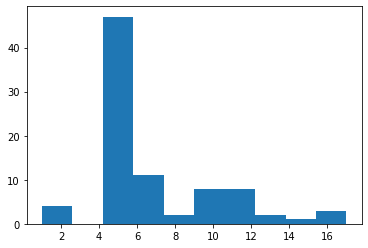

DescribeResult(nobs=86, minmax=(1, 17), mean=6.848837209302325, variance=10.741586867305063, skewness=1.2139127713235107, kurtosis=0.935189811638983)


In [81]:
actions_between_transfer = []
for obj in object_list_tracker:
    actions_between_transfer.append(object_list_tracker[obj]['time_since_pickup'])
    
plt.hist(actions_between_transfer)
plt.show()

print(stats.describe(actions_between_transfer))


In [ ]:
actions_bw_transfer_means = []
actions_bw_transfer_stds = []
scores = []

for trial_id in trial_data:
    time_since_pickup = trial_data[trial_id]['passed_object_steps']
#     print(time_since_pickup)
    num_actions_list = [time_since_pickup[obj]['time_since_pickup'] for obj in time_since_pickup]
    mean_num_actions = np.mean(num_actions_list)
    
    

In [105]:
actions_bw_transfer_means = []
actions_bw_transfer_stds = []
scores = []

for trial_id in trial_data:
    time_since_pickup = trial_data[trial_id]['passed_object_steps']
#     print(time_since_pickup)
    num_actions_list = [time_since_pickup[obj]['time_since_pickup'] for obj in time_since_pickup]
    mean_num_actions = np.mean(num_actions_list)
    actions_bw_transfer_means.append(mean_num_actions)
    actions_bw_transfer_stds.append(np.std(num_actions_list))
    score = trial_data[trial_id]['score']

    scores.append(score)
    
    

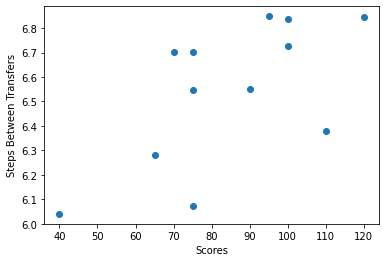

In [106]:
plt.scatter(scores, actions_bw_transfer_means)
plt.ylabel("Steps Between Transfers")
plt.xlabel("Scores")
plt.show()

Text(0.5, 1.0, 'variable, symmetric error')

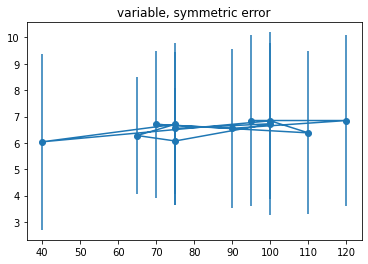

In [96]:
# plt.scatter(actions_bw_transfer, scores)
# plt.xlabel("Steps Between Transfers")
# plt.ylabel("Scores")
# plt.show()


# example data
x = np.array(scores)
y = np.array(actions_bw_transfer_means)


# example error bar values that vary with x-position
error = np.array(actions_bw_transfer_stds)

fig, ax = plt.subplots()
ax.errorbar(x, y, yerr=error, fmt='-o')
ax.set_title('variable, symmetric error')

# error bar values w/ different -/+ errors that
# also vary with the x-position
# lower_error = 0.4 * error
# upper_error = error
# asymmetric_error = [lower_error, upper_error]

# ax1.errorbar(x, y, xerr=asymmetric_error, fmt='o')
# ax1.set_title('variable, asymmetric error')
# ax1.set_yscale('log')
# plt.show()
